In [14]:
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy
from sklearn.model_selection import StratifiedKFold
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr
from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import get_ensg_id, estimate_s, CCC

In [2]:
def CCC(y_pred, y_true):
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    
    return numerator / denominator


In [4]:
plt.rcParams['font.size'] = '18'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '24'
legend_font = '18'
title_font = '30'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data

In [5]:
alldata = sc.read('/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01_raw.loom',validate=False)
alldata

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 15261 × 32285
    obs: 'barcode', 'class_label', 'obs_names', 'subclass_label'
    var: 'gene_name', 'var_names'
    layers: 'matrix', 'spliced', 'unspliced'

In [6]:
alldata.obs['sample'] = np.array([obs[-3:] for obs in alldata.obs['barcode']],dtype=str)
alldata.obs

,barcode,class_label,obs_names,subclass_label,sample
0,AAACCCAAGCCTGAGA_B02,GABAergic,AAACCCAAGCCTGAGA_B02,Vip,B02
1,AAACCCACACCCTAAA_B02,Glutamatergic,AAACCCACACCCTAAA_B02,L6 CT,B02
2,AAACCCAGTACAAGCG_B02,Glutamatergic,AAACCCAGTACAAGCG_B02,L6 CT,B02
3,AAACCCATCGCTCTCA_B02,GABAergic,AAACCCATCGCTCTCA_B02,Pvalb,B02
4,AAACCCATCGGACAAG_B02,Glutamatergic,AAACCCATCGGACAAG_B02,L5 IT,B02
...,...,...,...,...,...
15256,TTTGTTGGTCAGTCGC_H01,GABAergic,TTTGTTGGTCAGTCGC_H01,Pvalb,H01
15257,TTTGTTGGTTGCGAAG_H01,Glutamatergic,TTTGTTGGTTGCGAAG_H01,L6 CT,H01
15258,TTTGTTGTCCCTAGGG_H01,GABAergic,TTTGTTGTCCCTAGGG_H01,Pvalb,H01
15259,TTTGTTGTCCTGGTCT_H01,Glutamatergic,TTTGTTGTCCTGGTCT_H01,L6 IT,H01


In [7]:
alldata.obs.groupby(['sample']).size()

sample
B02    7792
H01    7469
dtype: int64

In [8]:
H01 = alldata[alldata.obs['sample'].isin(['H01'])]
H01

View of AnnData object with n_obs × n_vars = 7469 × 32285
    obs: 'barcode', 'class_label', 'obs_names', 'subclass_label', 'sample'
    var: 'gene_name', 'var_names'
    layers: 'matrix', 'spliced', 'unspliced'

In [9]:
B02 = alldata[alldata.obs['sample'].isin(['B02'])]
B02

View of AnnData object with n_obs × n_vars = 7792 × 32285
    obs: 'barcode', 'class_label', 'obs_names', 'subclass_label', 'sample'
    var: 'gene_name', 'var_names'
    layers: 'matrix', 'spliced', 'unspliced'

In [10]:
H01.obs.groupby(['subclass_label']).size()

subclass_label
L2/3 IT    1496
L5 ET       260
L5 IT      2267
L5/6 NP     284
L6 CT      1486
L6 IT       401
L6b         123
Lamp5       172
Pvalb       488
Sst         293
Vip         199
dtype: int64

In [11]:
adata = H01[H01.obs['subclass_label'].isin(['L5 IT'])]
adata

View of AnnData object with n_obs × n_vars = 2267 × 32285
    obs: 'barcode', 'class_label', 'obs_names', 'subclass_label', 'sample'
    var: 'gene_name', 'var_names'
    layers: 'matrix', 'spliced', 'unspliced'

# Calculate CV$^2$ of read depth

0.27407092 0.10064742


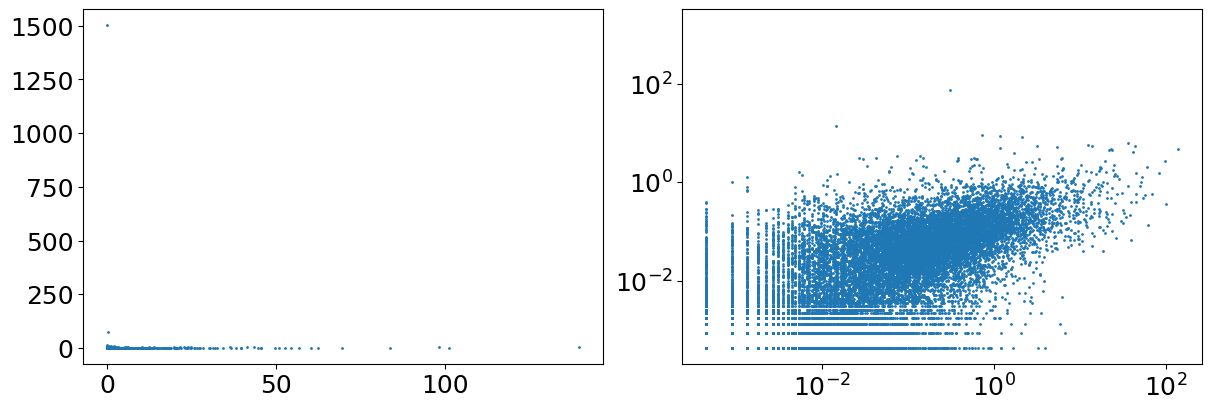

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

s estimated by total counts = 0.130054539880051
5729 su= 0.10366092714563477
8665 ss= 0.08488316968784326
3674 s= 0.08742195148518939


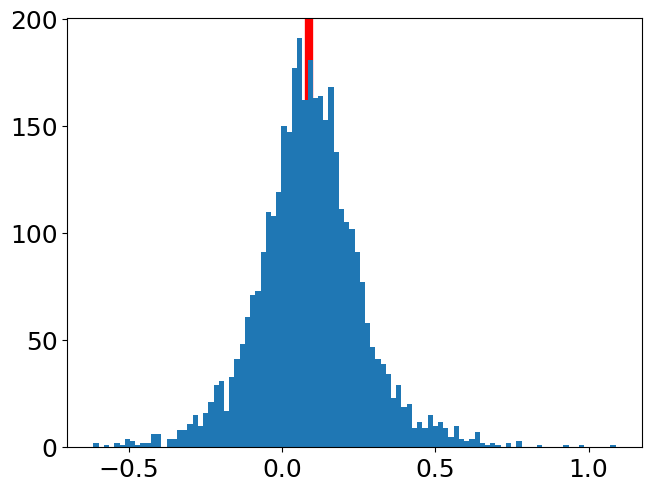

In [15]:
su, ss, sp = estimate_s(adata)

In [16]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.0) & (adata.layers["unspliced"].toarray().mean(0) > 0.0)
U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
U.sum(),S.sum()

(19868860.0, 3804150.0)

Text(0.02, 0.5, 'CV$^2$')

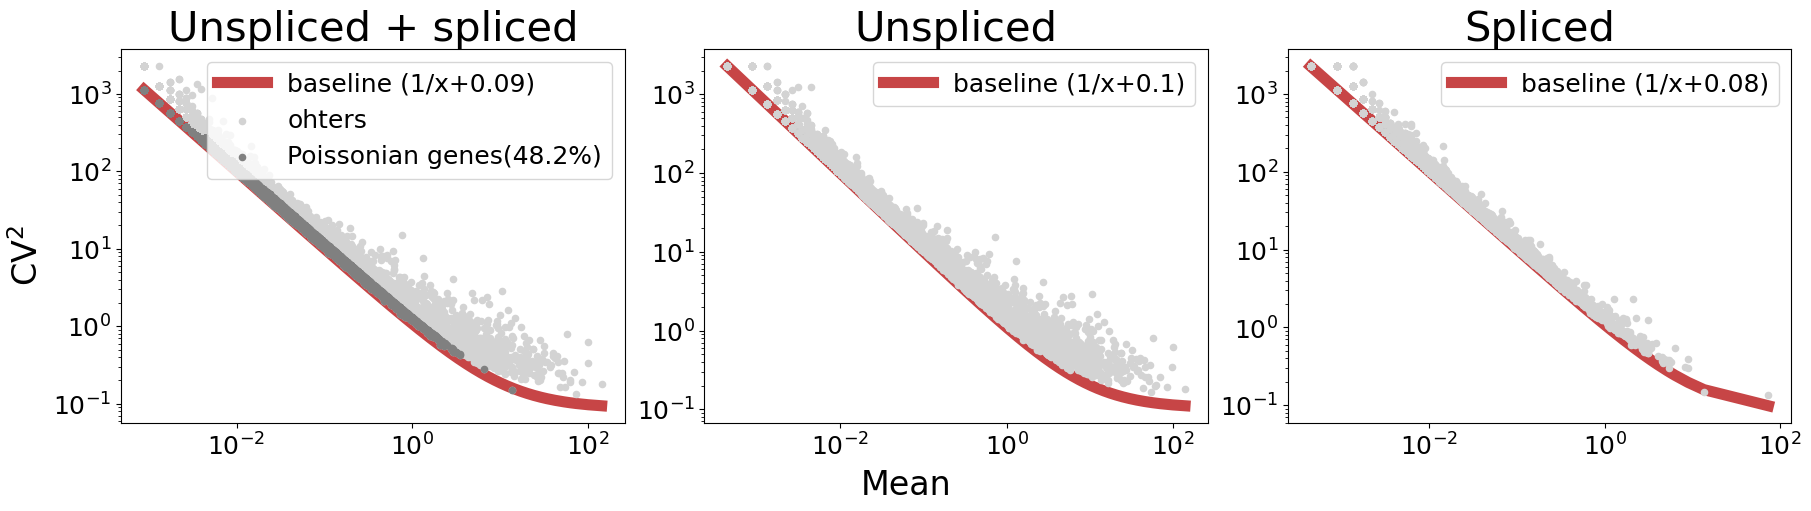

In [30]:
a=1

X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(a*X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), a/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), a/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
#ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), a/np.sort(S_mean) + ss, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
#ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes ('+str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

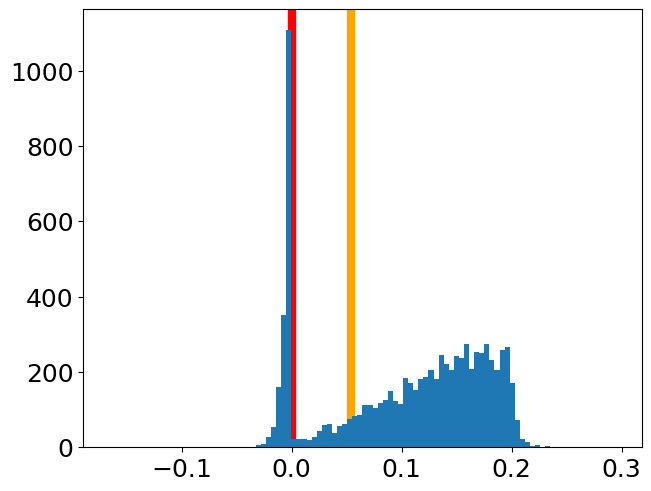

In [31]:
plt.hist((X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]-sp*X_mean[Pgene_mask],bins=100);
plt.axvline(x=0,c='r',zorder=0)
plt.axvline(x=0.05*(1+sp),c='orange',zorder=0)

# Check covariance relationships

In [44]:
min_mean = 0.5
idx = (adata.layers["spliced"].toarray().mean(0) > min_mean) & (adata.layers["unspliced"].toarray().mean(0) > min_mean)

U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = (cov_us)/S_mean/U_mean
zeta_us.shape

(347,)

## $Var(N_U)$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


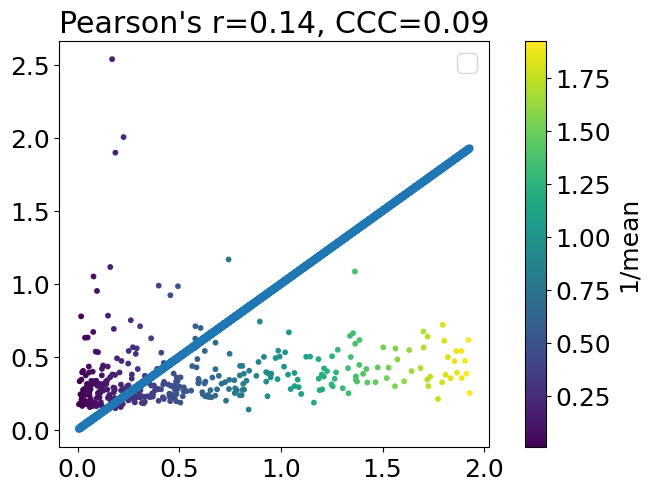

In [45]:
x = 1/U_mean
y = zeta_uu
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.plot(x,x)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

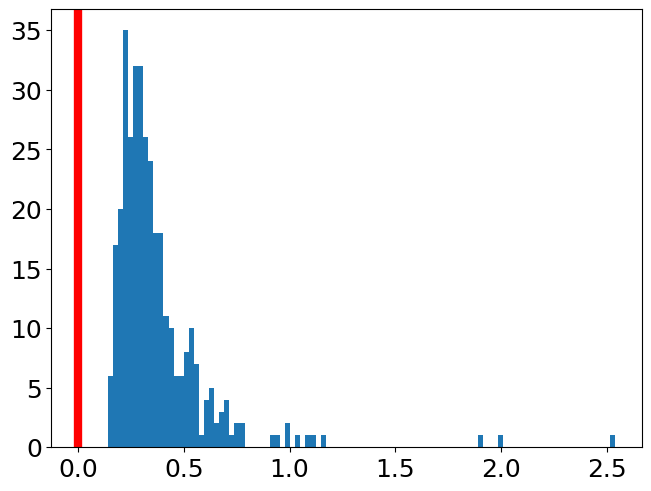

In [46]:
plt.hist(zeta_uu,bins=100);
plt.axvline(x=0,c='r')

## $Cov(N_u,N_s)$ 

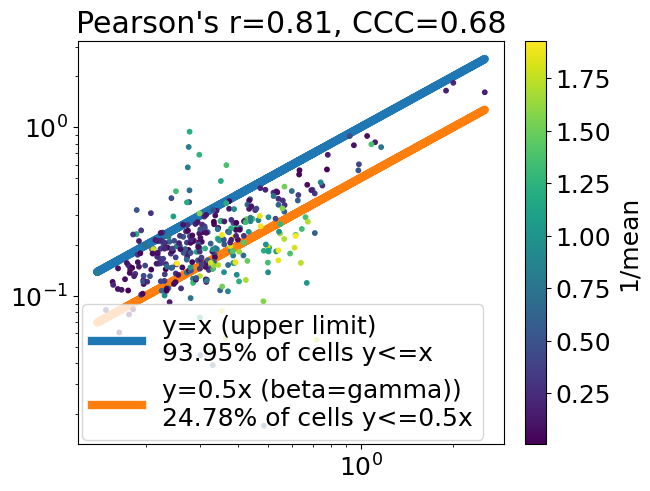

In [47]:
x=zeta_uu
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend(loc=(0.01,0.01))

## $Var(N_s)$ 

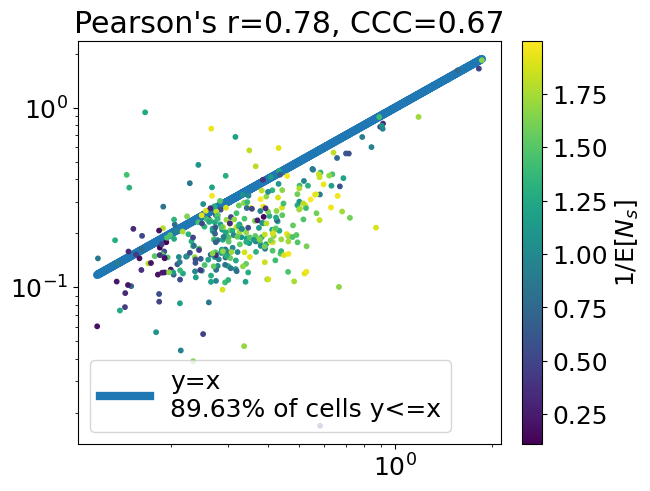

In [50]:
x=zeta_ss
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.scatter(x,y,s=10,alpha=1,c=1/S_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()